# Traitement des images

Deux approches : 
- **Approche SIFT/ORB** : 
Algorithme utilisé pour détecter et identifier les éléments similaires entre différentes images numériques.

- **Approche CNN (modèle pré-entraîné)** :
Réseau de neureunes d'apprentissage non-supervisé. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
from glob import iglob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Showing images

In [2]:
import os
from skimage.io import imread
from matplotlib.pyplot import imshow, show
from skimage.io import imread
import numpy as np

In [3]:
# define the location of the folder to go through
directory = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'

# get a list of files in that folder
file_list = os.listdir(directory)

file_list[0:5]

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

In [4]:
image_file_list = [file for file in file_list if file.endswith(".jpg")]

image_file_list[0:5]

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

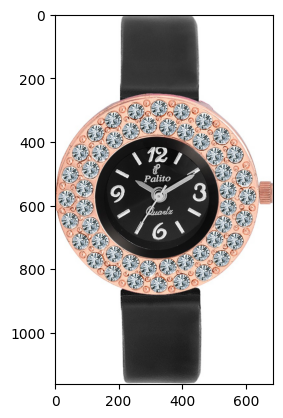

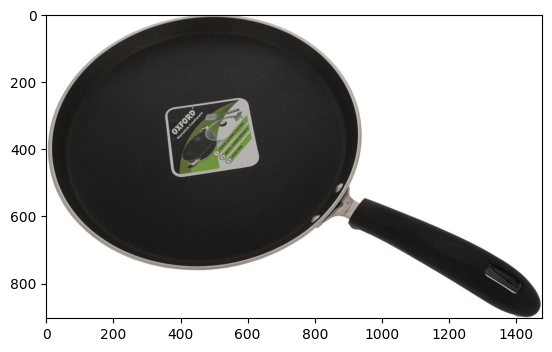

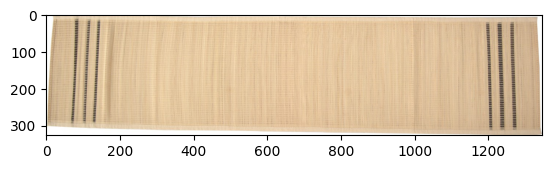

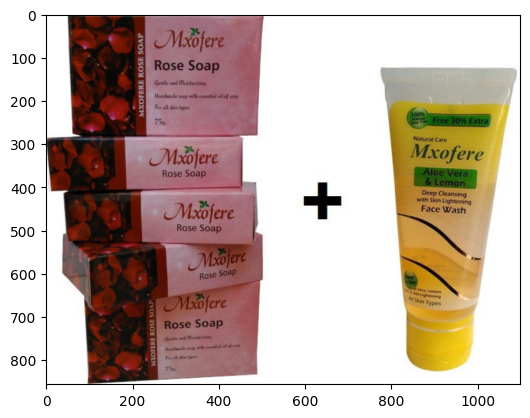

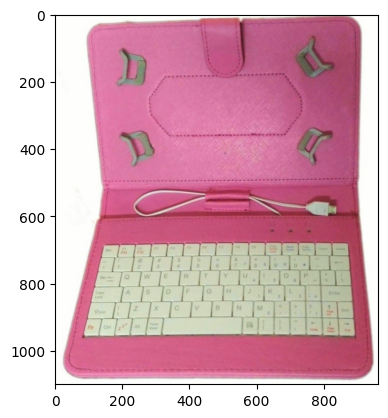

In [5]:
# go through all files in the folder
for image_file in image_file_list[0:5]:
    image = imread(directory + image_file)
    imshow(image)
    show()

# Importing dataset for labels 

Data is composed of :

one .csv file with descriptions and true categories
one file of pictures
Let's import at first the descriptions, product names and categories and put it in a dataframe.

In [6]:
# importing the categories product names and descriptions
df = pd.read_csv("/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')
print("-----> Importation of .csv in the notebook: OK")

df_pict = df[['product_name', 'description']].copy('deep')
df_pict.index = [s+'.jpg' for s in df_pict.index] 

-----> Importation of .csv in the notebook: OK


In [7]:
# --> user 35.2 s, sys: 1.19 s, total: 36.4 s Wall time: 37.5 s
#%%time
from PIL import Image
# to silence the decompression bomb warning
Image.MAX_IMAGE_PIXELS = 1000000000  

file_path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
li_files = df_pict.index

## importing pictures
dict_img_orig = {}
# loop on the pictures in the file
for i, ind in enumerate(li_files,1):
    print('\r', f"{i}/{len(list(li_files))}", end="")
    # cast each image to a np.array
    img = np.array(Image.open(file_path+ind))
    # put in the dictionnary
    dict_img_orig[ind] = img

dict_img_orig

 1050/1050

{'55b85ea15a1536d46b7190ad6fff8ce7.jpg': array([[[192, 184, 173],
         [192, 184, 173],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 184, 173],
         [193, 185, 174],
         [193, 185, 174],
         ...,
         [174, 165, 156],
         [174, 165, 156],
         [174, 165, 156]],
 
        [[192, 186, 174],
         [193, 187, 175],
         [193, 187, 175],
         ...,
         [175, 166, 157],
         [174, 165, 156],
         [174, 165, 156]],
 
        ...,
 
        [[209, 174, 136],
         [209, 174, 136],
         [209, 174, 136],
         ...,
         [130,  94,  96],
         [134,  99,  97],
         [139, 104, 100]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
         ...,
         [140, 105, 103],
         [143, 108, 102],
         [147, 113, 104]],
 
        [[210, 175, 137],
         [210, 175, 137],
         [210, 175, 137],
  

In [8]:
ser_img_orig = pd.Series(dict_img_orig,
                         index = df_pict.index,
                         name='img_orig')
df_pict = pd.concat([df_pict,
                     ser_img_orig.to_frame()], axis=1)

ser_img_orig.head()

55b85ea15a1536d46b7190ad6fff8ce7.jpg    [[[192, 184, 173], [192, 184, 173], [193, 185,...
7b72c92c2f6c40268628ec5f14c6d590.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
64d5d4a258243731dc7bbb1eef49ad74.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
d4684dcdc759dd9cdf41504698d737d8.jpg    [[[255, 255, 255], [255, 255, 255], [255, 255,...
6325b6870c54cd47be6ebfbffa620ec7.jpg    [[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...
Name: img_orig, dtype: object

In [9]:
df_pict.head()

product_name   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Elegance Polyester Multicolor Abstract Eyelet ...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg                         Sathiyas Cotton Bath Towel   
64d5d4a258243731dc7bbb1eef49ad74.jpg                Eurospa Cotton Terry Face Towel Set   
d4684dcdc759dd9cdf41504698d737d8.jpg  SANTOSH ROYAL FASHION Cotton Printed King size...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Jaipur Print Cotton Floral King sized Double B...   

                                                                            description   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Key Features of Elegance Polyester Multicolor ...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  Specifications of Sathiyas Cotton Bath Towel (...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  Key Features of Eurospa Cotton Terry Face Towe...   
d4684dcdc759dd9cdf41504698d737d8.jpg  Key Features of SANTOSH ROYAL FASHION Cotton P...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Key Features of Jaipur Print Cotton Floral Kin...   

                                                                               img_orig  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  [[[192, 184, 173], [192, 184, 173], [193, 185,...  
7b72c92c2f6c40268628ec5f14c6d590.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
64d5d4a258243731dc7bbb1eef49ad74.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
d4684dcdc759dd9cdf41504698d737d8.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
6325b6870c54cd47be6ebfbffa620ec7.jpg  [[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...

# Finding the categories


In [10]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()

max_depth

6

In [11]:
def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))

In [12]:
ser_tuple.head()

uniq_id
55b85ea15a1536d46b7190ad6fff8ce7    (Home Furnishing, Curtains & Accessories, Curt...
7b72c92c2f6c40268628ec5f14c6d590    (Baby Care, Baby Bath & Skin, Baby Bath Towels...
64d5d4a258243731dc7bbb1eef49ad74    (Baby Care, Baby Bath & Skin, Baby Bath Towels...
d4684dcdc759dd9cdf41504698d737d8    (Home Furnishing, Bed Linen, Bedsheets, SANTOS...
6325b6870c54cd47be6ebfbffa620ec7    (Home Furnishing, Bed Linen, Bedsheets, Jaipur...
Name: product_category_tree, dtype: object

In [13]:
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df_pict.index)

df_cat_level.head()

cat_level_0   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  \
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   

                                                                 cat_level_1   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing/Curtains & Accessories  \
7b72c92c2f6c40268628ec5f14c6d590.jpg              Baby Care/Baby Bath & Skin   
64d5d4a258243731dc7bbb1eef49ad74.jpg              Baby Care/Baby Bath & Skin   
d4684dcdc759dd9cdf41504698d737d8.jpg               Home Furnishing/Bed Linen   
6325b6870c54cd47be6ebfbffa620ec7.jpg               Home Furnishing/Bed Linen   

                                                                          cat_level_2   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing/Curtains & Accessories/Curtains  \
7b72c92c2f6c40268628ec5f14c6d590.jpg      Baby Care/Baby Bath & Skin/Baby Bath Towels   
64d5d4a258243731dc7bbb1eef49ad74.jpg      Baby Care/Baby Bath & Skin/Baby Bath Towels   
d4684dcdc759dd9cdf41504698d737d8.jpg              Home Furnishing/Bed Linen/Bedsheets   
6325b6870c54cd47be6ebfbffa620ec7.jpg              Home Furnishing/Bed Linen/Bedsheets   

                                                                            cat_level_3   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing/Curtains & Accessories/Curtain...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...   
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...   

                                                                            cat_level_4   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing/Curtains & Accessories/Curtain...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...   
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...   

                                                                            cat_level_5  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing/Curtains & Accessories/Curtain...  
7b72c92c2f6c40268628ec5f14c6d590.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Sa...  
64d5d4a258243731dc7bbb1eef49ad74.jpg  Baby Care/Baby Bath & Skin/Baby Bath Towels/Eu...  
d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing/Bed Linen/Bedsheets/SANTOSH RO...  
6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing/Bed Linen/Bedsheets/Jaipur Pri...

In [14]:
# Put categories in the dataframe

ser_cat = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                         'Baby Care': 'Baby', 
                                         'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})

df_pict.insert(2, 'category', ser_cat)

In [15]:
df_pict.head()

product_name   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Elegance Polyester Multicolor Abstract Eyelet ...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg                         Sathiyas Cotton Bath Towel   
64d5d4a258243731dc7bbb1eef49ad74.jpg                Eurospa Cotton Terry Face Towel Set   
d4684dcdc759dd9cdf41504698d737d8.jpg  SANTOSH ROYAL FASHION Cotton Printed King size...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Jaipur Print Cotton Floral King sized Double B...   

                                                                            description   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Key Features of Elegance Polyester Multicolor ...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  Specifications of Sathiyas Cotton Bath Towel (...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  Key Features of Eurospa Cotton Terry Face Towe...   
d4684dcdc759dd9cdf41504698d737d8.jpg  Key Features of SANTOSH ROYAL FASHION Cotton P...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Key Features of Jaipur Print Cotton Floral Kin...   

                                        category   
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Furnishing  \
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby   
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby   
d4684dcdc759dd9cdf41504698d737d8.jpg  Furnishing   
6325b6870c54cd47be6ebfbffa620ec7.jpg  Furnishing   

                                                                               img_orig  
55b85ea15a1536d46b7190ad6fff8ce7.jpg  [[[192, 184, 173], [192, 184, 173], [193, 185,...  
7b72c92c2f6c40268628ec5f14c6d590.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
64d5d4a258243731dc7bbb1eef49ad74.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
d4684dcdc759dd9cdf41504698d737d8.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
6325b6870c54cd47be6ebfbffa620ec7.jpg  [[[99, 99, 91], [80, 80, 72], [67, 67, 57], [6...

In [16]:
df_pict.category.unique()

array(['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers'], dtype=object)

In [17]:
df_pict.to_csv("projet_6_images.csv")

# Exploratory data analysis

In [18]:
from sklearn import preprocessing
# define the location of the folder to go through

path = "/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/*.jpg"

directory="/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/" 


#data_path = iglob(path+'**/*.jpg') 
data_path=glob(path)

def data_fct(path,directory,df) :
    list_photos = [file for file in path]
    print(len(list_photos))
    
    #Initialising dataframes
    data_pic = pd.DataFrame()
    data_cat=pd.DataFrame()
    
    # Creating columns
    data_pic["image_path"] = list_photos
    data_pic['id'] = data_pic['image_path'].map(lambda x: x.lstrip(directory).lstrip('\\'))
    
    data_cat["id"]=df.index
    
    # Combined dataset creation
    data=data_cat.merge(data_pic,how='inner',on='id')
    
    #Set index the id 
    data=data.set_index('id')
    
    # Add label 
    data["label_name"] = df["category"]
    
    return data

data=data_fct(data_path,directory,df_pict)

data.head()

1050


image_path   
id                                                                                        
55b85ea15a1536d46b7190ad6fff8ce7.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
d4684dcdc759dd9cdf41504698d737d8.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   

                                      label_name  
id                                                
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Furnishing  
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby  
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby  
d4684dcdc759dd9cdf41504698d737d8.jpg  Furnishing  
6325b6870c54cd47be6ebfbffa620ec7.jpg  Furnishing

In [19]:
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data.head(5)

image_path   
id                                                                                        
55b85ea15a1536d46b7190ad6fff8ce7.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...  \
7b72c92c2f6c40268628ec5f14c6d590.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
64d5d4a258243731dc7bbb1eef49ad74.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
d4684dcdc759dd9cdf41504698d737d8.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   
6325b6870c54cd47be6ebfbffa620ec7.jpg  /Users/kherm/Documents/Openclassrooms/projet 6...   

                                      label_name  label  
id                                                       
55b85ea15a1536d46b7190ad6fff8ce7.jpg  Furnishing      4  
7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby      0  
64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby      0  
d4684dcdc759dd9cdf41504698d737d8.jpg  Furnishing      4  
6325b6870c54cd47be6ebfbffa620ec7.jpg  Furnishing      4

In [20]:
data.groupby("label").count()

image_path  label_name
label                        
0             150         150
1             150         150
2             150         150
3             150         150
4             150         150
5             150         150
6             150         150

In [21]:
data.label_name.unique()

array(['Furnishing', 'Baby', 'Watches', 'Decor', 'Kitchen', 'Beauty',
       'Computers'], dtype=object)

In [26]:
data.to_csv("projet_6_fichier_pathway_avant_modelisation_images.csv")

# Etape 1 : étude de faisabilité

# Prétraitement images 

## 1. Essai sur une image

55b85ea15a1536d46b7190ad6fff8ce7.jpg


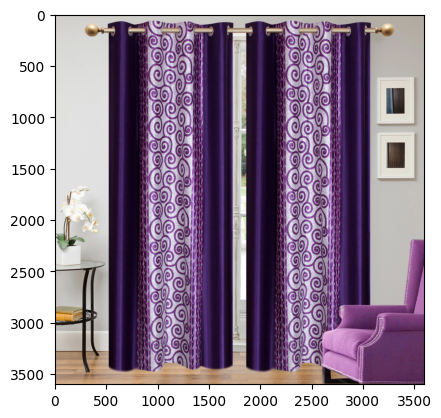

In [34]:

from matplotlib.image import imread

path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
print(df.image.head()[0])
filename = path + df.image.head()[0]
image = imread(filename)
plt.imshow(image)
plt.show()

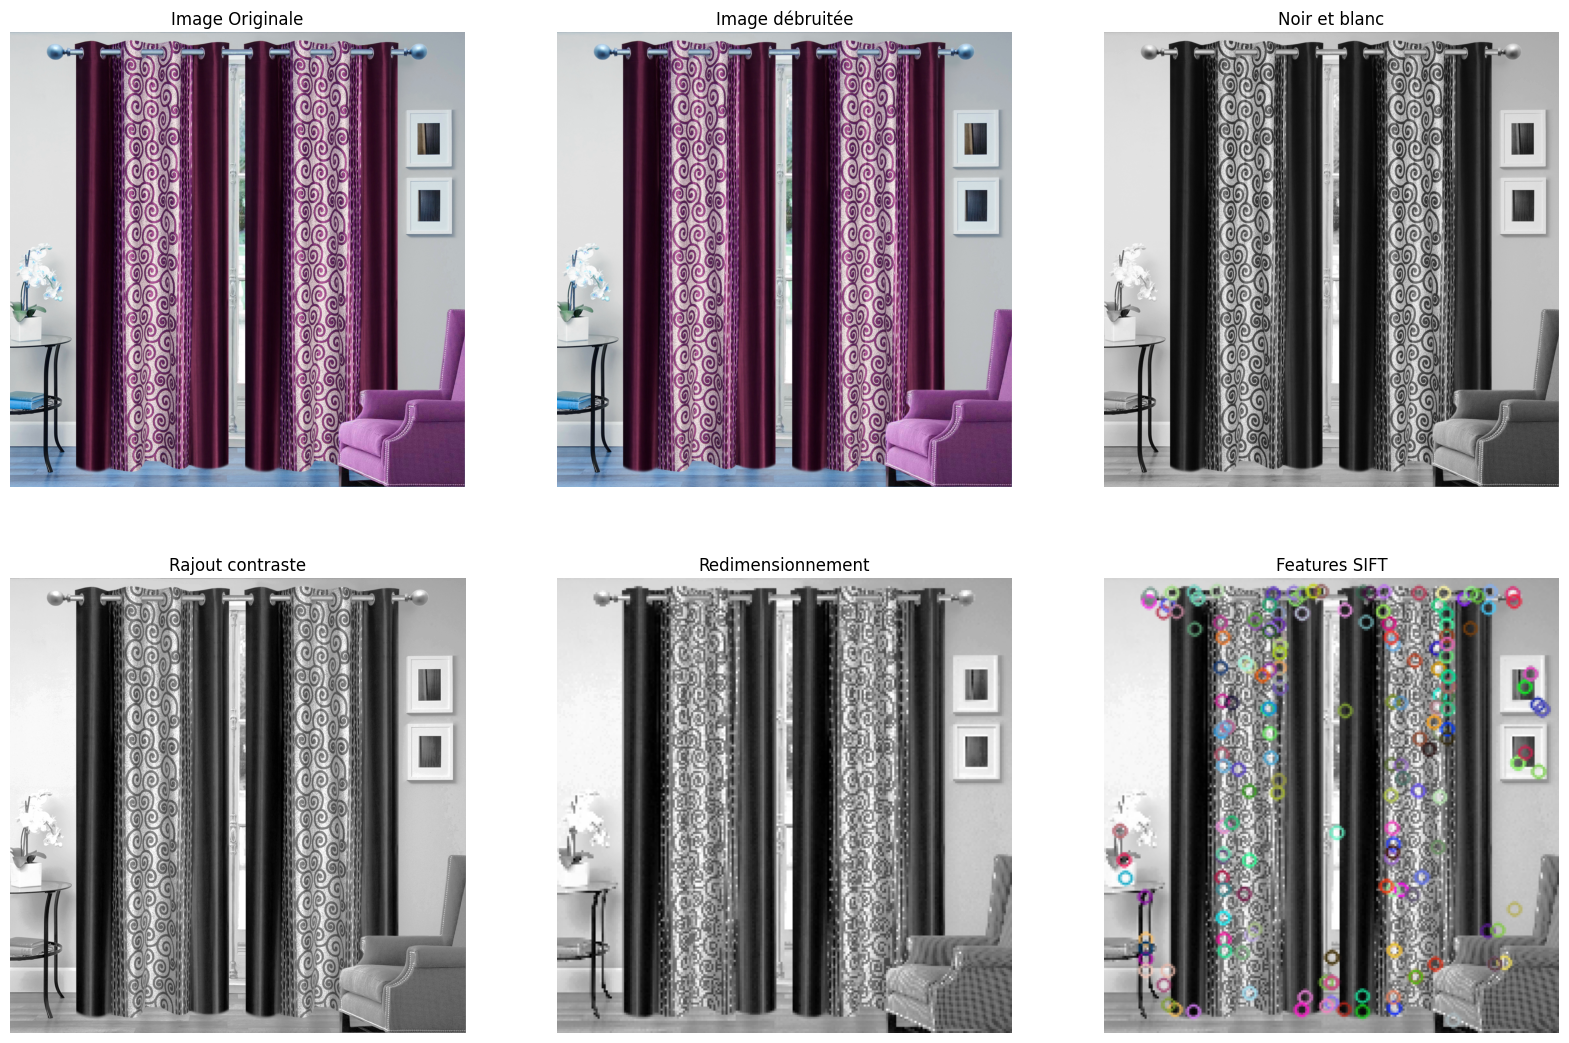

In [51]:
# Image originale
import cv2

path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
filename = path + df.image.head()[0]

sift = cv2.SIFT_create(200)
image = cv2.imread(filename)

plt.figure(figsize=(20, 13))

plt.subplot(2,3,1)
plt.axis('off')
plt.title('Image Originale')
plt.imshow(image)

plt.subplot(2,3,2)

# Remove Noise (enlève le bruit) 
image = cv2.GaussianBlur(image, (5, 5), 0)
plt.axis('off')
plt.title('Image débruitée')
plt.imshow(image)

#Passage en noir et blanc
plt.subplot(2,3,3)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.title('Noir et blanc')
plt.imshow(gray_img,cmap='gray')

#Augmentation du contraste par égalisation du contraste
plt.subplot(2,3,4)
image = cv2.equalizeHist(gray_img)   # equalize image histogram
plt.axis('off')
plt.title('Rajout contraste')
plt.imshow(image, cmap='gray')

#Redimensionnement pour normaliser entrée
plt.subplot(2,3,5)
dsize = (224, 224)
image = cv2.resize(image, dsize)
plt.axis('off')
plt.title('Redimensionnement')
plt.imshow(image, cmap='gray')

#Détecion feature SIFT
plt.subplot(2,3,6)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,gray_img)
plt.axis('off')
plt.title('Features SIFT')
plt.imshow(img)

plt.savefig('P01_07_traitementImages.jpg')
plt.show()

In [54]:
def pretraitement_image(image_name):
    path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
    filename = path + image_name
    image = imread(filename)

    sift = cv2.SIFT_create(200)
    image = cv2.imread(filename)

    plt.figure(figsize=(20, 13))

    plt.subplot(2,3,1)
    plt.axis('off')
    plt.title('Image Originale')
    plt.imshow(image)

    plt.subplot(2,3,2)
    
    #Supprimer le bruit
    image = cv2.GaussianBlur(image, (5, 5), 0)
    plt.axis('off')
    plt.title('Image débruitée')
    plt.imshow(image)

    # noir et blanc
    plt.subplot(2,3,3)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    plt.title('Noir et blanc')
    plt.imshow(gray_img,cmap='gray')

    #Augmentation du contraste par égalisation du contraste
    plt.subplot(2,3,4)
    image = cv2.equalizeHist(gray_img)   # equalize image histogram
    plt.axis('off')
    plt.title('Rajout contraste')
    plt.imshow(image, cmap='gray')

    #on redimensionne pour normaliser entrée
    plt.subplot(2,3,5)
    dsize = (224, 224)
    image = cv2.resize(image, dsize)
    plt.axis('off')
    plt.title('Redimensionnement')
    plt.imshow(image, cmap='gray')

    #detecion feature SIFT
    plt.subplot(2,3,6)

    kp, des = sift.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image,kp,gray_img)
    plt.axis('off')
    plt.title('features SIFT')
    plt.imshow(img)
    plt.show()

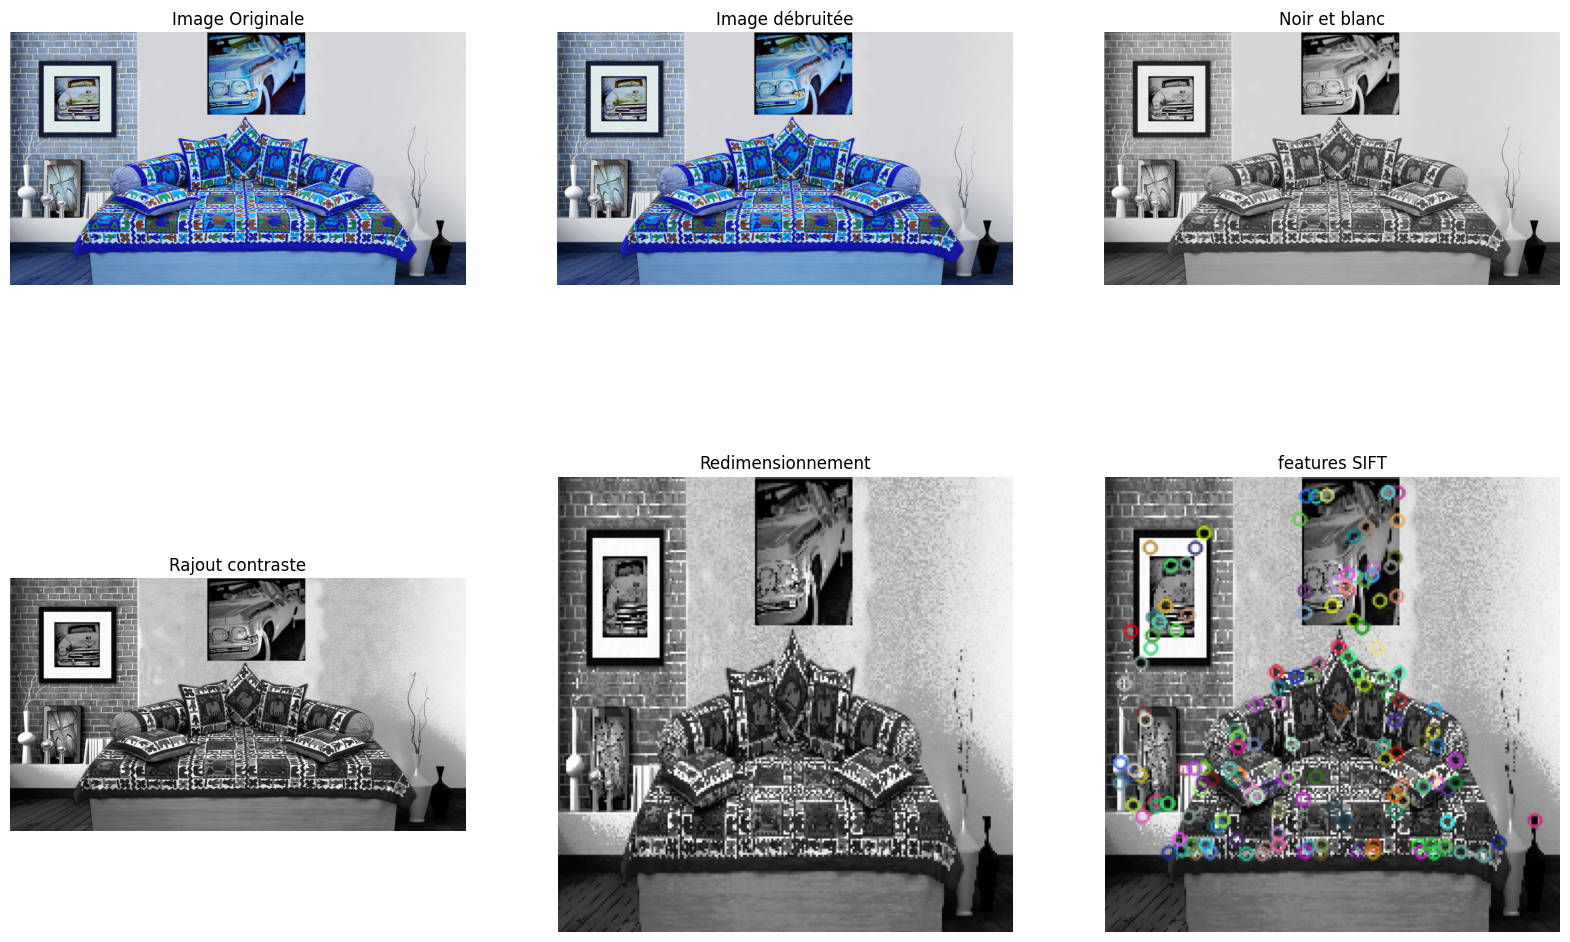

In [56]:
pretraitement_image('0a8a1e9c6659361c0c2b247f8a6471d0.jpg')

## Création des descripteurs de chaque image
Pour chaque image: 
- Passage en gris et équalisation
- Création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
- Création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs.

In [59]:
data_pic=pd.read_csv('projet_6_fichier_pathway_avant_modelisation_images.csv')
data_pic.head()

id   
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                          image_path  label_name  label  
0  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
1  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
2  /Users/kherm/Documents/Openclassrooms/projet 6...        Baby      0  
3  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4  
4  /Users/kherm/Documents/Openclassrooms/projet 6...  Furnishing      4

In [60]:
df_model=data_pic.copy()

In [64]:
# identification of key points and associated descriptors
import time, cv2


list_photos =  df_model['id'].values.tolist()

sift_keypoints = []
orb_keypoints = []

temps1=time.time()
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

for image_num in range(len(list_photos)) :
    if image_num%25 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num])
    image = cv2.GaussianBlur(image, (5, 5), 0)
    gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    equal_img = cv2.equalizeHist(gray_img)   # equalize image histogram
    dsize = (224, 224)
    resize_image = cv2.resize(equal_img, dsize)
    kp, des = sift.detectAndCompute(resize_image, None)
    sift_keypoints.append(des)
    kp, des = orb.detectAndCompute(resize_image, None)
    orb_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)
orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)




#print()
print("Nombre de descripteurs SIFT : ", sift_keypoints_all.shape)
print("Nombre de descripteurs  ORB : ",  orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
Nombre de descripteurs SIFT :  (347754, 128)
Nombre de descripteurs  ORB :  (383338, 32)
temps de traitement SIFT descriptor :            49.65 secondes


C:\Users\kherm\AppData\Local\Temp\ipykernel_1680\119737697.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)
C:\Users\kherm\AppData\Local\Temp\ipykernel_1680\119737697.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  orb_keypoints_by_img = np.asarray(orb_keypoints)


## Création des clusters de descripteurs
Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [65]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k_sift = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k_sift)
print("Création de",k_sift, "clusters de descripteurs ...")

# Clustering
kmeans_sift = cluster.MiniBatchKMeans(n_clusters=k_sift, init_size=3*k_sift, random_state=1972)
kmeans_sift.fit(sift_keypoints_all)

k_orb = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k_orb)
print("Création de",k_orb, "clusters de descripteurs ...")

kmeans_orb = cluster.MiniBatchKMeans(n_clusters=k_orb, init_size=3*k_orb, random_state=1972)
kmeans_orb.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  590
Création de 590 clusters de descripteurs ...


C:\Users\kherm\anaconda\envs\Notebook_text\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Nombre de clusters estimés :  619
Création de 619 clusters de descripteurs ...


C:\Users\kherm\anaconda\envs\Notebook_text\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


temps de traitement kmeans :            15.83 secondes


## Création des features des images
Pour chaque image :
- prédiction des numéros de cluster de chaque descripteur
- création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
- Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [66]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors_sift=[]
hist_vectors_orb=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%200 == 0 : print(i)  
    hist = build_histogram(kmeans_sift, image_desc, i) #calculates the histogram
    hist_vectors_sift.append(hist) #histogram is the feature vector

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%200 == 0 : print(i)  
    hist = build_histogram(kmeans_orb, image_desc, i) #calculates the histogram
    hist_vectors_orb.append(hist) #histogram is the feature vector

    
im_features_sift = np.asarray(hist_vectors_sift)
im_features_orb = np.asarray(hist_vectors_orb)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
200
400
600
800
1000
0
200
400
600
800
1000
temps de création histogrammes :             4.63 secondes



## Réduction de dimension PCA
La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [67]:
from sklearn import manifold, decomposition

print("Dimensions dataset SIFT avant réduction PCA : ", im_features_sift.shape)
pca_sift = decomposition.PCA(n_components=0.99)
feat_pca_sift = pca_sift.fit_transform(im_features_sift)
print("Dimensions dataset SIFT après réduction PCA : ", feat_pca_sift.shape)

print("Dimensions dataset  ORB avant réduction PCA : ", im_features_orb.shape)
pca_orb = decomposition.PCA(n_components=0.99)
feat_pca_orb = pca_orb.fit_transform(im_features_orb)
print("Dimensions dataset  ORB après réduction PCA : ", feat_pca_orb.shape)

Dimensions dataset SIFT avant réduction PCA :  (1050, 590)
Dimensions dataset SIFT après réduction PCA :  (1050, 474)
Dimensions dataset  ORB avant réduction PCA :  (1050, 619)
Dimensions dataset  ORB après réduction PCA :  (1050, 510)


In [68]:
from sklearn.cluster import KMeans

km_sift =  KMeans(n_clusters = 7, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km_sift.fit(feat_pca_sift)

km_orb =  KMeans(n_clusters = 7, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km_orb.fit(feat_pca_orb)

KMeans(n_clusters=7, n_init=10, random_state=0)

In [70]:
from sklearn.metrics.cluster import adjusted_rand_score

ari_tf = adjusted_rand_score(df_model['label_name'], km_sift.labels_)
ari_bow = adjusted_rand_score(df_model['label_name'], km_orb.labels_)

print(f'ARI BOW: {ari_bow:.3f}')
print(f'ARI TFIDF: {ari_tf:.3f}')

ARI BOW: 0.015
ARI TFIDF: 0.024


## Réduction de dimension T-SNE
Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [72]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=1944)

X_tsne_sift = tsne.fit_transform(feat_pca_sift)
df_tsne_sift = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
print(X_tsne_sift.shape)

X_tsne_orb = tsne.fit_transform(feat_pca_orb)
df_tsne_orb = pd.DataFrame(X_tsne_orb[:,0:2], columns=['tsne1', 'tsne2'])
print(X_tsne_orb.shape)

(1050, 2)
(1050, 2)


In [73]:
df_tsne_sift['label_name'] = df_model['label_name']
df_tsne_orb['label_name'] = df_model['label_name']

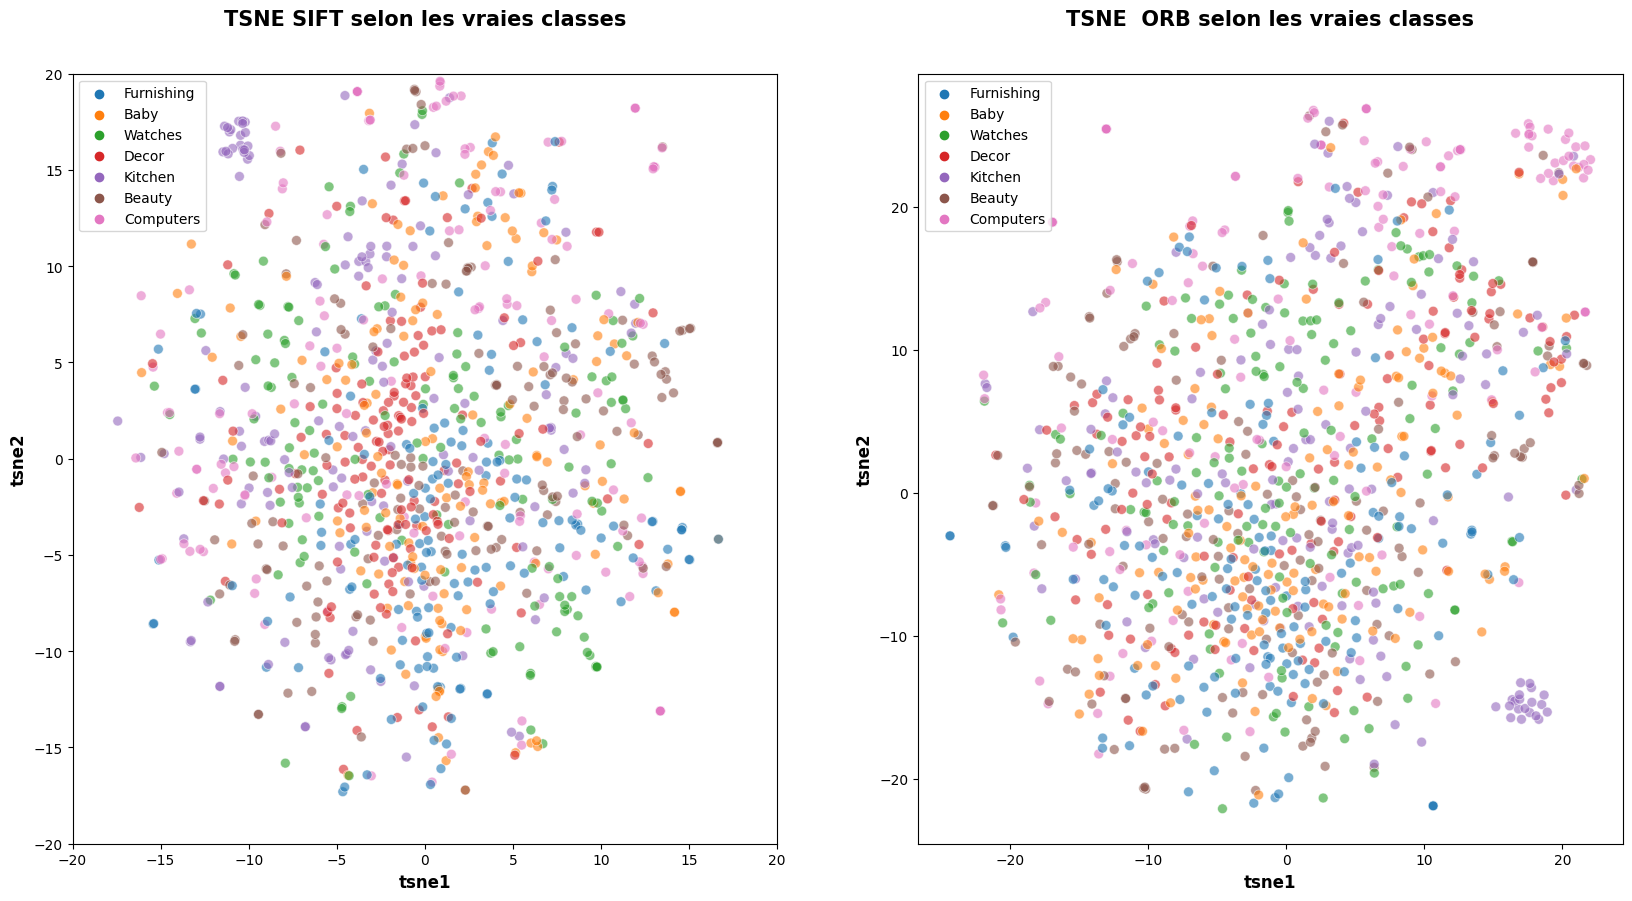

In [76]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue='label_name', s=50, alpha=0.6)
plt.title('TSNE SIFT selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.legend(prop={'size': 10}) 

plt.subplot(1,2,2)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_orb, legend="brief", hue='label_name', s=50, alpha=0.6)
plt.title('TSNE  ORB selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 12, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

# Création du modèle pré-entraîné  VGG16

In [78]:

#Load model
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [79]:
# identification of key points and associated descriptors
import time, cv2

path = '/Users/kherm/Documents/Openclassrooms/projet 6/Flipkart/Images/'
list_photos =  df_model['id'].values.tolist()

vgg_keypoints = []

temps1=time.time()

for image_num in range(len(list_photos)) :
    if image_num%50 == 0 : print(image_num)
    # load an image from file
    image = load_img(path+list_photos[image_num], target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    #reduction bruit
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    features = model.predict(image)
    vgg_keypoints.append(features)

vgg_keypoints_by_img = np.asarray(vgg_keypoints)
vgg_keypoints_all    = np.concatenate(vgg_keypoints_by_img, axis=0)

print("Nombre de descripteurs VGG : ", vgg_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement VGG descriptor : ", "%15.2f" % duration1, "secondes")

0
1/1 [==============================] - 0s 331ms/step
50
1/1 [==============================] - 0s 309ms/step
100
1/1 [==============================] - 0s 308ms/step
150
1/1 [==============================] - 0s 293ms/step
200
1/1 [==============================] - 0s 296ms/step
250
1/1 [==============================] - 0s 317ms/step
300
1/1 [==============================] - 0s 297ms/step
350
1/1 [==============================] - 0s 326ms/step
400
1/1 [==============================] - 0s 297ms/step
450
1/1 [==============================] - 0s 339ms/step
500
1/1 [==============================] - 0s 283ms/step
550
1/1 [==============================] - 0s 295ms/step
600
1/1 [==============================] - 0s 304ms/step
650
1/1 [==============================] - 0s 349ms/step
700
1/1 [==============================] - 0s 298ms/step
750
1/1 [==============================] - 0s 313ms/step
800
1/1 [==============================] - 0s 316ms/step
850
1/1 [=========================

### PCA

In [85]:
from sklearn import manifold, decomposition

print("Dimensions avant  réduction PCA : " ,vgg_keypoints_all.shape)

pca_vgg = decomposition.PCA(n_components=0.99)
feat_pca_vgg= pca_vgg.fit_transform(vgg_keypoints_all)
print("Dimensions après réduction PCA : ", feat_pca_vgg.shape)


Dimensions avant  réduction PCA :  (1050, 4096)
Dimensions après réduction PCA :  (1050, 793)


In [86]:
from sklearn.cluster import KMeans

km_vgg = KMeans(n_clusters=7)
km_vgg.fit(vgg_keypoints_all)

km_vgg_acp = KMeans(n_clusters=7)
km_vgg_acp.fit(feat_pca_vgg)

C:\Users\kherm\anaconda\envs\Notebook_text\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kherm\anaconda\envs\Notebook_text\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=7)

In [87]:
from sklearn.metrics.cluster import adjusted_rand_score

ari = adjusted_rand_score(df_model['label_name'], km_vgg.labels_)
ari_acp = adjusted_rand_score(df_model['label_name'], km_vgg_acp.labels_)

print(f'ARI     : {ari:.3f}')
print(f'ARI ACP : {ari_acp:.3f}')

ARI     : 0.440
ARI ACP : 0.437


In [88]:
!pip install mpl_toolkits

ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits


### TSNE

In [90]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=40, 
                     n_iter=2000, init='random', random_state=1944)

X_tsne_sift = tsne.fit_transform(vgg_keypoints_all)
df_tsne_sift = pd.DataFrame(X_tsne_sift, columns=['tsne1', 'tsne2'])
print(X_tsne_sift.shape)

(1050, 2)


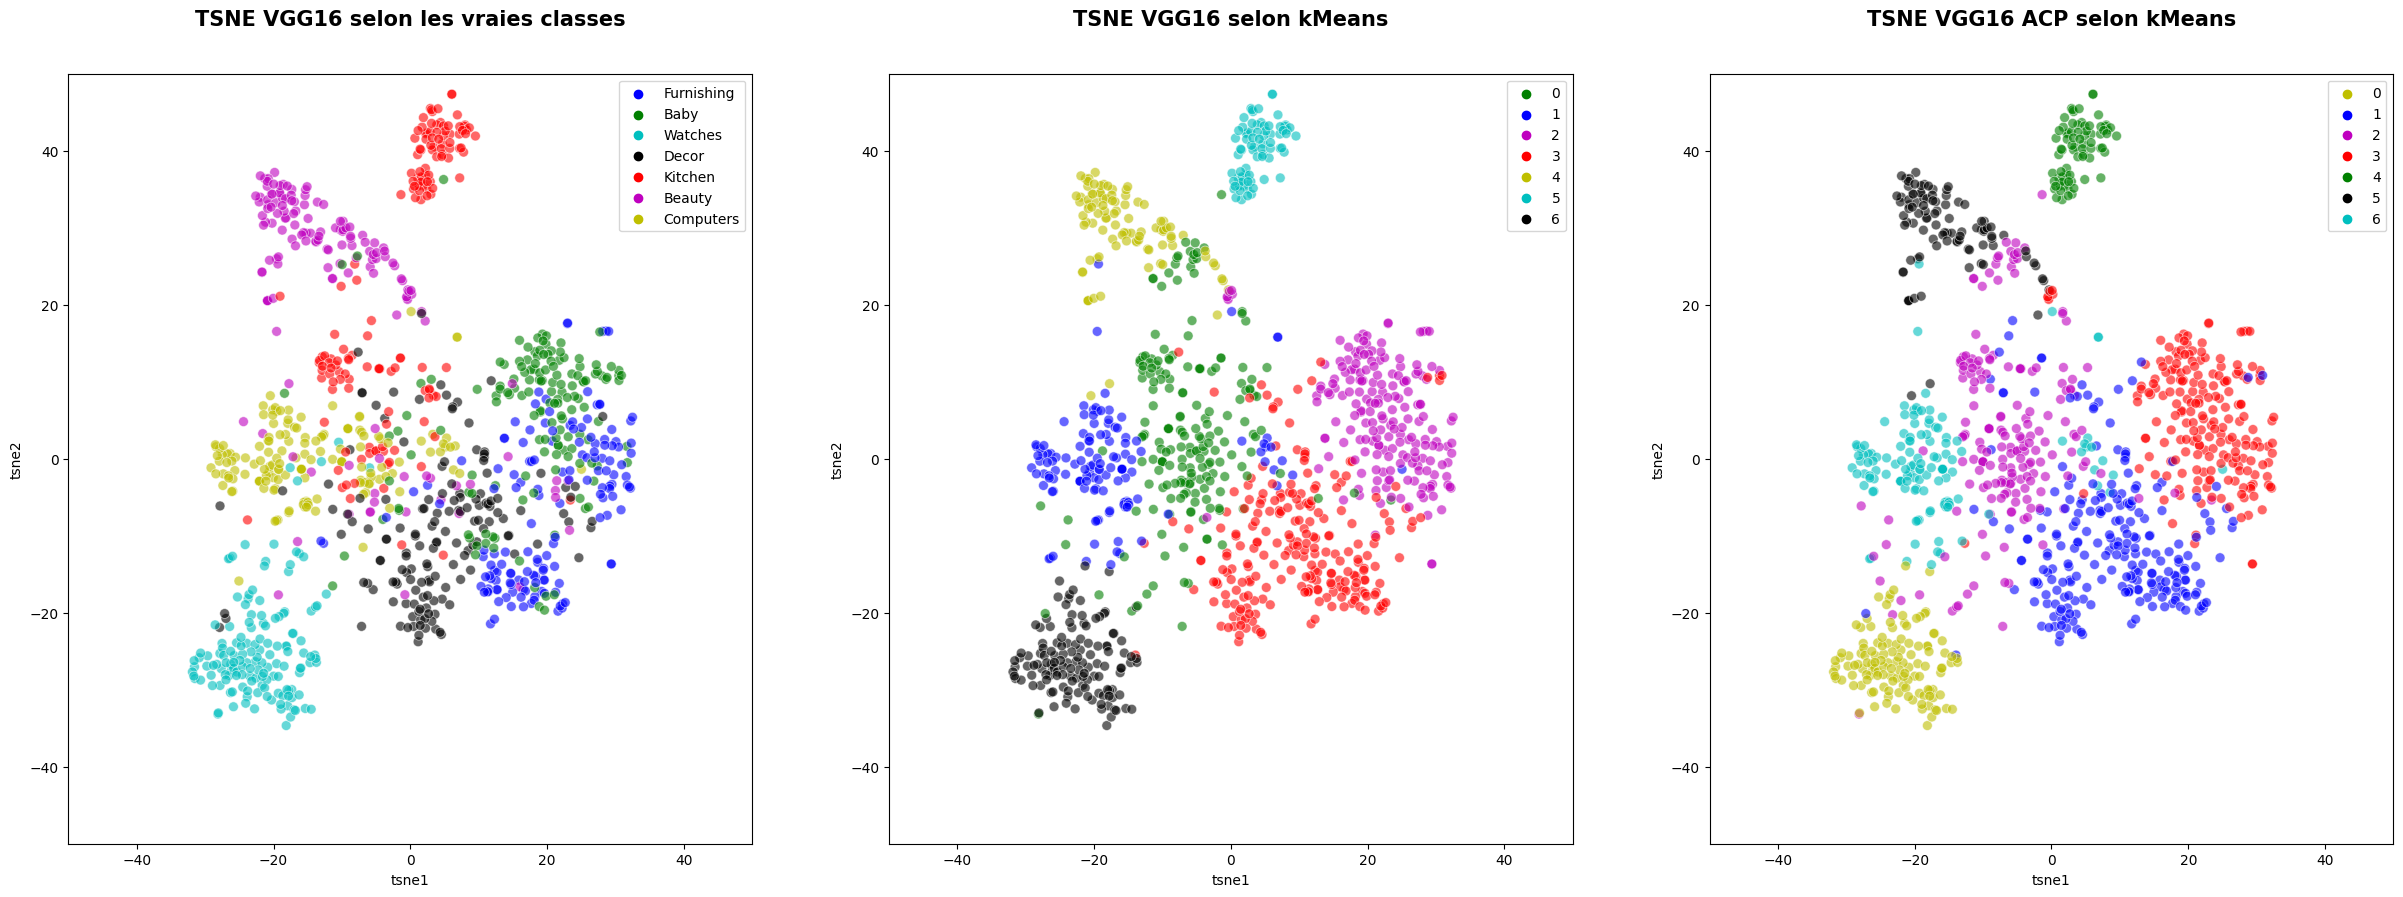

In [92]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
my_pal = {"Baby": "g", "Furnishing": "b", "Beauty":"m", "Kitchen": "r", 
          "Computers": "y", "Watches":"c", "Decor":"k"}
#sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=df.iloc[index_train,:]['category'], s=50, alpha=0.6, palette=my_pal)
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=df_model['label_name'], s=50, alpha=0.6, palette=my_pal)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.title('TSNE VGG16 selon les vraies classes', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.subplot(1,3,2)
my_pal = {0: "g", 1: "b", 2:"m", 3: "r", 4: "y", 5:"c", 6:"k"}
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=km_vgg.labels_, s=50, alpha=0.6, palette=my_pal)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.title('TSNE VGG16 selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.subplot(1,3,3)
my_pal = {0: "y", 1: "b", 2:"m", 3: "r", 4: "g", 5:"k", 6:"c"}
sns.scatterplot(   x="tsne1", y="tsne2", data=df_tsne_sift, legend="brief", hue=km_vgg_acp.labels_, s=50, alpha=0.6, palette=my_pal)
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.title('TSNE VGG16 ACP selon kMeans', fontsize = 15, pad = 35, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

#plt.savefig('P01_11_VGG16_Kmeans.jpg')
plt.show()

### Reste brouillon 

In [147]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [204]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.8)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 147)


In [205]:
feat_pca[0]

array([ -5.6892614 ,  21.233887  ,   2.0968366 ,   2.440862  ,
       -37.423626  , -10.677186  , -20.2112    ,  -5.9295774 ,
        -2.3671398 ,   2.2316084 ,   4.2222204 ,   2.146111  ,
        -2.3605866 ,  -4.114473  ,   3.0788374 ,   3.3102267 ,
         3.8949502 ,  -4.7843585 ,  -0.0448362 ,   6.1695642 ,
        -1.7564985 ,   0.35009426,  -8.089109  , -10.695425  ,
        -0.5247666 ,  11.748331  ,  -1.9230317 ,   4.1734834 ,
        -0.990053  ,   7.5021396 ,   0.90399176,  -4.48734   ,
         5.8815866 ,   3.6490445 ,  -1.9776753 ,   2.2169597 ,
        -4.069709  ,  -0.7539691 ,   1.1378912 ,   2.6266575 ,
        -8.037887  ,  -2.9888492 ,  -3.2899077 ,   2.9914918 ,
        -4.019329  ,  -0.1162769 ,   5.8429093 ,   6.8997126 ,
        -1.6912665 ,  -3.2756069 ,  -1.1359804 ,  13.316351  ,
         3.8390324 ,   0.181838  ,  -5.0671606 ,   2.1755145 ,
         1.4170347 ,   5.5273986 ,  -4.2278643 ,   2.038277  ,
         1.612381  ,   1.2539726 ,   0.9151652 ,  -5.35

### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [206]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             6.91 secondes


In [207]:
X_tsne.shape

(1050, 2)

In [189]:
df_tsne.head()

tsne1      tsne2 class
0   1.128627  28.238195   NaN
1  14.817321   3.063354   NaN
2  21.596279   9.329119   NaN
3   8.353039  30.781029   NaN
4   8.640962  34.729385   NaN

In [ ]:
fig = px.scatter(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], color=y_train)
fig.update_layout(
    title="t-SNE visualization dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data


### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement

In [194]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

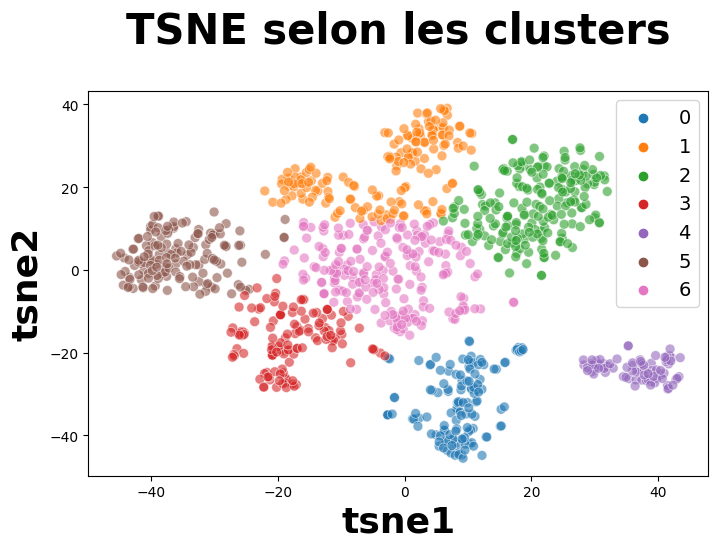

ARI :  0.4443968823747949


In [196]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# test 

In [201]:
X = data.drop('label', axis=1)
X = X.drop(columns=['label_name','image_path'], axis=1)
y = data['label']
y.head()

id
55b85ea15a1536d46b7190ad6fff8ce7.jpg    4
7b72c92c2f6c40268628ec5f14c6d590.jpg    0
64d5d4a258243731dc7bbb1eef49ad74.jpg    0
d4684dcdc759dd9cdf41504698d737d8.jpg    4
6325b6870c54cd47be6ebfbffa620ec7.jpg    4
Name: label, dtype: int32